## Load data

In [2]:
import sys
sys.path.append('../')
from utilities import *

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import matplotlib


In [4]:
# Define the database folder path and file names
db_folder = '../../data/processed_data/yelp_data/'
data_files = ['business', 'categories', 'review', 'user']

# Load data into a dictionary
yelp_data = load_data_from_db(db_folder, data_files)

# Check loaded data
for table, df in yelp_data.items():
    print(f"Loaded {len(df)} rows from {table} table.")

Loaded 78059 rows from business table.
Loaded 360656 rows from categories table.
Loaded 980418 rows from review table.
Loaded 229447 rows from user table.


In [5]:
df_business = yelp_data["business"]
df_review = yelp_data["review"]
df_user = yelp_data["user"]

In [65]:
df_user = df_user[['user_id', 'yelping_since']]

# Add year column to df_review if not already present
df_review['date'] = pd.to_datetime(df_review['date'])
df_review['year'] = df_review['date'].dt.year

df_user['yelping_since'] = pd.to_datetime(df_user['yelping_since'])

current_date = pd.to_datetime('2021-12-31')  # Using current date as reference

## Data sparity

In [72]:
# 1. Review Distribution (Users)
def analyze_user_reviews(df_review, k=5):
    # Count reviews per user
    user_review_counts = df_review.groupby('user_id').size()
    
    # Calculate percentage of users with fewer than k reviews
    users_below_k = (user_review_counts < k).sum()
    total_users = len(user_review_counts)
    percentage = (users_below_k / total_users) * 100
    
    stats_text = (f"Percentage of users with fewer than {k} reviews: {percentage:.2f}%")
    
    # Set Seaborn style for improved aesthetics
    sns.set_style("whitegrid")  # Adds a grid for better readability
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Plot histogram using Seaborn
    g = sns.histplot(data=user_review_counts, bins=50)
    g.set_yscale('log')  # Set y-axis to log scale for better visualization of skewed data
    # Customize the plot
    plt.xlim(0, 600)  # Limit x-axis to 600
    plt.axvline(x=k, color='red', linestyle='--', label=f'{k} reviews')  # Add vertical line
    plt.title('Distribution of Reviews per User', fontsize=14, pad=10)
    plt.xlabel('Number of Reviews', fontsize=12)
    plt.ylabel('Number of Users (log scale)', fontsize=12)
    plt.legend()
    plt.text(0.95, 0.85, stats_text, transform=plt.gca().transAxes, 
            fontsize=10, verticalalignment='top', horizontalalignment='right', 
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))
    # Display the plot
    plt.show()

# 2. Review Distribution (Businesses)
def analyze_business_reviews(df_business, k=5):
    # Use review_count from df_business
    business_review_counts = df_business['review_count']
    
    # Calculate percentage of businesses with fewer than k reviews
    businesses_below_k = (business_review_counts < k).sum()
    total_businesses = len(business_review_counts)
    percentage = (businesses_below_k / total_businesses) * 100
    
    print(f"Percentage of businesses with fewer than {k} reviews: {percentage:.2f}%")
    
    # Set Seaborn style
    sns.set_style("whitegrid")
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Plot histogram using Seaborn
    g = sns.histplot(data=business_review_counts, bins=50)
    g.set_yscale('log')
    # Customize the plot
    plt.xlim(0, 6000)
    plt.axvline(x=k, color='red', linestyle='--', label=f'{k} reviews')
    plt.title('Distribution of Reviews per Business', fontsize=14, pad=10)
    plt.xlabel('Number of Reviews', fontsize=12)
    plt.ylabel('Number of Businesses (log scale)', fontsize=12)
    plt.legend()
    
    # Display the plot
    plt.show()

# 3. Matrix Sparsity
def calculate_sparsity(df_review):
    # Get unique users and businesses
    n_users = df_review['user_id'].nunique()
    n_businesses = df_review['business_id'].nunique()
    
    # Actual interactions (reviews)
    n_reviews = len(df_review)
    
    # Total possible interactions
    total_possible = n_users * n_businesses
    
    # Sparsity ratio
    sparsity = 1 - (n_reviews / total_possible)
    density = n_reviews / total_possible
    
    print(f"Matrix Sparsity: {sparsity:.4f}")
    print(f"Matrix Density: {density:.4f}")
    print(f"Actual interactions: {n_reviews}")
    print(f"Possible interactions: {total_possible}")

# 4. Temporal Perspective
def analyze_temporal(df_review, df_business):
    # Convert date to datetime and extract year
    df_review['year'] = pd.to_datetime(df_review['date']).dt.year
    
    # Count reviews per year
    reviews_per_year = df_review.groupby('year').size()
    
    # Get first review year per user and business
    user_first_review = df_review.groupby('user_id')['year'].min()
    business_first_review = df_review.groupby('business_id')['year'].min()
    
    # Count new users and businesses per year
    new_users_per_year = user_first_review.value_counts().sort_index()
    new_businesses_per_year = business_first_review.value_counts().sort_index()
    
    # Set Seaborn style
    sns.set_style("whitegrid")
    
    # Create figure
    plt.figure(figsize=(12, 6))
    
    # Prepare data for Seaborn (convert to DataFrame for lineplot)
    data = pd.DataFrame({
        'Year': reviews_per_year.index,
        'New Reviews': reviews_per_year.values,
        'New Users': new_users_per_year.reindex(reviews_per_year.index, fill_value=0).values,
        'New Businesses': new_businesses_per_year.reindex(reviews_per_year.index, fill_value=0).values
    })
    
    # Plot using Seaborn
    sns.lineplot(x='Year', y='New Reviews', data=data, label='New Reviews', color='blue')
    sns.lineplot(x='Year', y='New Users', data=data, label='New Users', color='green')
    sns.lineplot(x='Year', y='New Businesses', data=data, label='New Businesses', color='orange')
    
    # Customize the plot
    plt.ylim(0, 120000)  # Set y-axis limit
    plt.title('Temporal Growth Analysis', fontsize=14, pad=10)
    plt.xticks(data['Year'], rotation=35)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    
    # Format x-axis as "Jan YYYY"
    plt.gca().xaxis.set_major_formatter(lambda x, pos: f"Jan {int(x)}" if x == int(x) else "")
    plt.gca().tick_params(axis='x', rotation=45)  # Rotate labels for readability
    
    plt.legend()
    
    # Display the plot
    plt.show()



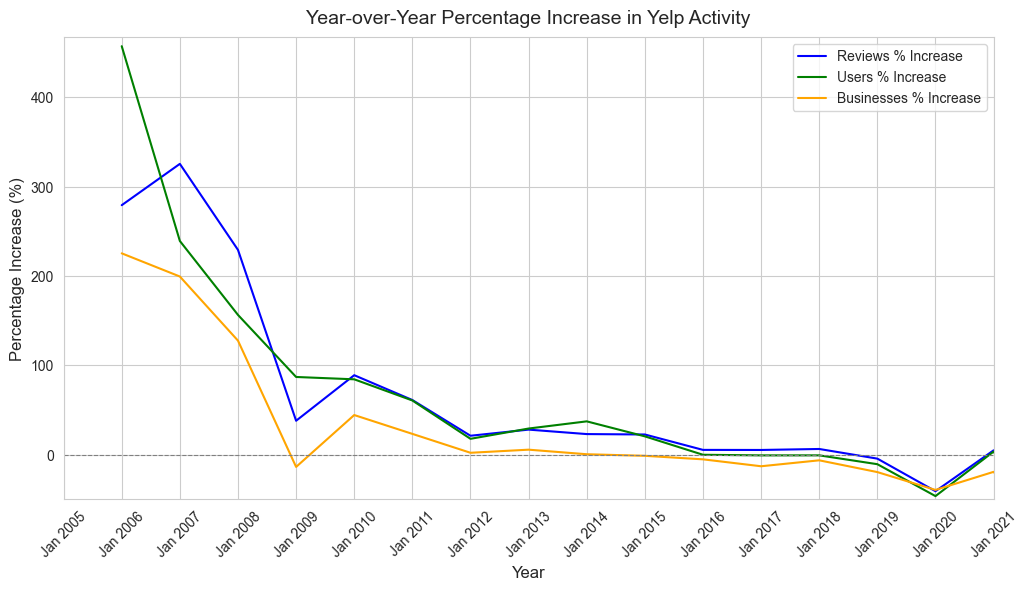

In [ ]:
def analyze_temporal(df_review, df_business):
    
    # Count reviews per year
    reviews_per_year = df_review.groupby('year').size()
    
    # Get first review year per user and business
    user_first_review = df_review.groupby('user_id')['year'].min()
    business_first_review = df_review.groupby('business_id')['year'].min()
    
    # Count new users and businesses per year
    new_users_per_year = user_first_review.value_counts().sort_index()
    new_businesses_per_year = business_first_review.value_counts().sort_index()
    
    # Calculate percentage increase from previous year
    reviews_pct_change = reviews_per_year.pct_change() * 100  # Convert to percentage
    users_pct_change = new_users_per_year.pct_change() * 100
    businesses_pct_change = new_businesses_per_year.pct_change() * 100
    
    # Prepare data for plotting (align indices and fill NaN for first year)
    data = pd.DataFrame({
        'Year': reviews_per_year.index,
        'Reviews % Increase': reviews_pct_change.reindex(reviews_per_year.index, fill_value=0).values,
        'Users % Increase': users_pct_change.reindex(reviews_per_year.index, fill_value=0).values,
        'Businesses % Increase': businesses_pct_change.reindex(reviews_per_year.index, fill_value=0).values
    })
    
    # Set Seaborn style
    sns.set_style("whitegrid")
    
    # Create figure
    plt.figure(figsize=(12, 6))
    
    # Plot using Seaborn
    sns.lineplot(x='Year', y='Reviews % Increase', data=data, label='Reviews % Increase', color='blue')
    sns.lineplot(x='Year', y='Users % Increase', data=data, label='Users % Increase', color='green')
    sns.lineplot(x='Year', y='Businesses % Increase', data=data, label='Businesses % Increase', color='orange')
    
    # Customize the plot
    plt.title('Year-over-Year Percentage Increase in Yelp Activity', fontsize=14, pad=10)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Percentage Increase (%)', fontsize=12)
    plt.xticks(data['Year'], rotation=45)
    
    # Format x-axis as "Jan YYYY"
    plt.gca().xaxis.set_major_formatter(lambda x, pos: f"Jan {int(x)}" if x == int(x) else "")
    plt.gca().tick_params(axis='x', rotation=45)  # Rotate labels for readability
    
    # Add horizontal line at 0% for reference
    plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
    
    # Adjust y-axis limit dynamically based on data (optional)
    plt.ylim(-50,
             max(data[['Reviews % Increase', 'Users % Increase', 'Businesses % Increase']].max()) + 10)
    plt.xlim(data['Year'].min(), 2021)  # Set x-axis limit
    
    plt.legend()
    
    # Display the plot
    plt.show()

# Example usage
analyze_temporal(df_review, df_business)

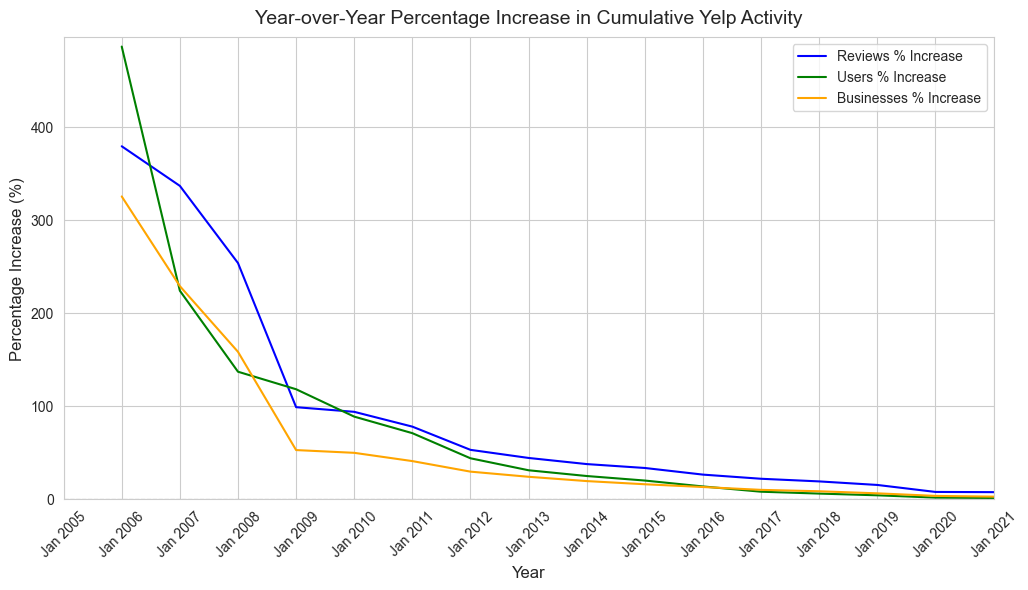

In [73]:

def analyze_temporal(df_review, df_business, df_user):
    # Cumulative reviews: count all reviews up to and including each year
    reviews_cumulative = df_review.groupby('year').size().cumsum()

    # Cumulative users: count users who joined on or before each year
    df_user['join_year'] = df_user['yelping_since'].dt.year
    users_cumulative = df_user.groupby('join_year').size().cumsum().reindex(reviews_cumulative.index, fill_value=0)
    
    # Cumulative businesses: count businesses with first review on or before each year
    business_first_review = df_review.groupby('business_id')['year'].min()
    businesses_cumulative = business_first_review.value_counts().sort_index().cumsum().reindex(reviews_cumulative.index, fill_value=0)
    
    # Calculate percentage increase from previous year based on cumulative counts
    reviews_pct_change = reviews_cumulative.pct_change() * 100  # Convert to percentage
    users_pct_change = users_cumulative.pct_change() * 100
    businesses_pct_change = businesses_cumulative.pct_change() * 100
    
    # Prepare data for plotting (align indices and fill NaN for first year)
    data = pd.DataFrame({
        'Year': reviews_cumulative.index,
        'Reviews % Increase': reviews_pct_change.reindex(reviews_cumulative.index, fill_value=0).values,
        'Users % Increase': users_pct_change.reindex(reviews_cumulative.index, fill_value=0).values,
        'Businesses % Increase': businesses_pct_change.reindex(reviews_cumulative.index, fill_value=0).values
    })
    
    # Set Seaborn style
    sns.set_style("whitegrid")
    
    # Create figure
    plt.figure(figsize=(12, 6))
    
    # Plot using Seaborn
    sns.lineplot(x='Year', y='Reviews % Increase', data=data, label='Reviews % Increase', color='blue')
    sns.lineplot(x='Year', y='Users % Increase', data=data, label='Users % Increase', color='green')
    sns.lineplot(x='Year', y='Businesses % Increase', data=data, label='Businesses % Increase', color='orange')
    
    # Customize the plot
    plt.title('Year-over-Year Percentage Increase in Cumulative Yelp Activity', fontsize=14, pad=10)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Percentage Increase (%)', fontsize=12)
    plt.xticks(data['Year'], rotation=45)
    
    # Format x-axis as "Jan YYYY"
    plt.gca().xaxis.set_major_formatter(lambda x, pos: f"Jan {int(x)}" if x == int(x) else "")
    plt.gca().tick_params(axis='x', rotation=45)  # Rotate labels for readability
    
    # Add horizontal line at 0% for reference
    plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
    
    # Adjust y-axis limit dynamically based on data
    plt.ylim(0, max(data[['Reviews % Increase', 'Users % Increase', 'Businesses % Increase']].max()) + 10)
    plt.xlim(data['Year'].min(), 2021)  # Adjust x-axis limit as needed
    
    plt.legend()
    
    # Display the plot
    plt.show()

# Example usage (ensure df_user is passed as an argument)
analyze_temporal(df_review, df_business, df_user)

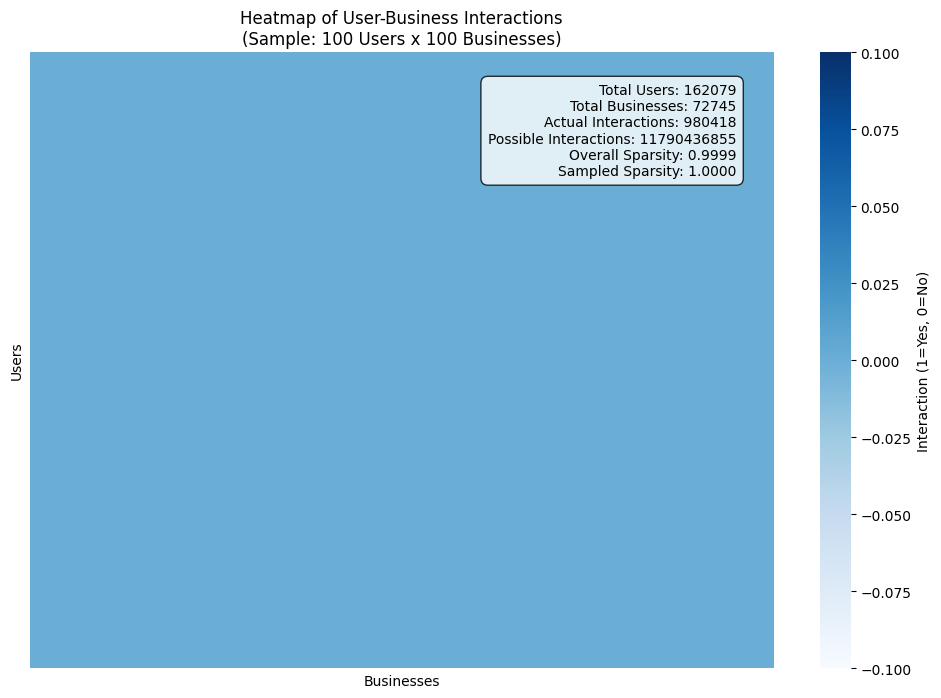

In [10]:
def calculate_sparsity(df_review, sample_users=100, sample_businesses=100):
    # Get unique users and businesses
    n_users = df_review['user_id'].nunique()
    n_businesses = df_review['business_id'].nunique()
    
    # Actual interactions (reviews)
    n_reviews = len(df_review)
    
    # Total possible interactions
    total_possible = n_users * n_businesses
    
    # Sparsity and density ratios
    sparsity = 1 - (n_reviews / total_possible)
    density = n_reviews / total_possible
    
    # Sample a subset of users and businesses for visualization
    sampled_users = df_review['user_id'].drop_duplicates().sample(n=min(sample_users, n_users), 
                                                                 random_state=42)
    sampled_businesses = df_review['business_id'].drop_duplicates().sample(n=min(sample_businesses, n_businesses), 
                                                                          random_state=42)
    
    # Filter reviews to only include sampled users and businesses
    sampled_reviews = df_review[
        df_review['user_id'].isin(sampled_users) & 
        df_review['business_id'].isin(sampled_businesses)
    ]
    
    # Create a pivot table for the heatmap (1 for interaction, 0 for no interaction)
    interaction_matrix = sampled_reviews.pivot_table(
        index='user_id', 
        columns='business_id', 
        values='review_id', 
        aggfunc='count', 
        fill_value=0
    ).astype(bool).astype(int)  # Convert to binary (1 = interaction, 0 = no interaction)
    
    # Ensure the matrix includes all sampled users and businesses, filling missing with 0
    interaction_matrix = interaction_matrix.reindex(
        index=sampled_users, 
        columns=sampled_businesses, 
        fill_value=0
    )
    
    # Calculate sparsity for the sampled subset
    sampled_sparsity = 1 - (interaction_matrix.sum().sum() / (sample_users * sample_businesses))
    
    # Prepare statistics text
    stats_text = (
        f"Total Users: {n_users}\n"
        f"Total Businesses: {n_businesses}\n"
        f"Actual Interactions: {n_reviews}\n"
        f"Possible Interactions: {total_possible}\n"
        f"Overall Sparsity: {sparsity:.4f}\n"
        f"Sampled Sparsity: {sampled_sparsity:.4f}"
    )
    
    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(interaction_matrix, 
                cmap='Blues', 
                cbar_kws={'label': 'Interaction (1=Yes, 0=No)'}, 
                xticklabels=False, 
                yticklabels=False)
    plt.title(f'Heatmap of User-Business Interactions\n(Sample: {sample_users} Users x {sample_businesses} Businesses)')
    plt.xlabel('Businesses')
    plt.ylabel('Users')
    
    # Add text box with statistics
    plt.text(0.95, 0.95, stats_text, 
             transform=plt.gca().transAxes, 
             fontsize=10, 
             verticalalignment='top', 
             horizontalalignment='right', 
             bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))
    
    plt.show()

# Example usage
calculate_sparsity(df_review, sample_users=100, sample_businesses=100)

## Cold start

In [6]:
# find the latest date in yelp_since in df_user
latest_yelping_since = df_user['yelping_since'].max()
latest_yelping_since

'2022-01-19 17:15:36'

In [71]:
# 1. Proportion of New Users / Businesses
def analyze_new_entities(df_review, timeframe='year'):
    # Get first appearance of users and businesses
    user_first = df_review.groupby('user_id')['date'].min()
    business_first = df_review.groupby('business_id')['date'].min()
    
    # Aggregate by timeframe (year only for simplicity as per your code)
    new_users = user_first.dt.year.value_counts().sort_index()
    new_businesses = business_first.dt.year.value_counts().sort_index()
    time_label = 'Year'
    index = new_users.index
    
    # Prepare data for Seaborn
    data = pd.DataFrame({
        time_label: index,
        'New Users': new_users.reindex(index, fill_value=0).values,
        'New Businesses': new_businesses.reindex(index, fill_value=0).values
    })
    
    # Set Seaborn style
    sns.set_style("whitegrid")
    
    # Create figure
    plt.figure(figsize=(12, 6))
    
    # Plot using Seaborn
    sns.lineplot(x=time_label, y='New Users', data=data, label='New Users', color='blue', linewidth=2.5)
    sns.lineplot(x=time_label, y='New Businesses', data=data, label='New Businesses', color='green', linewidth=2.5)
    
    # Customize the plot
    plt.ylim(0, 20000)  # Set y-axis limit
    plt.title(f'Number of New Users and Businesses per {timeframe.capitalize()}', fontsize=14, pad=10)
    plt.xlabel(time_label, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(data['Year'], rotation=35)  # Retain your custom rotation
    plt.gca().xaxis.set_major_formatter(lambda x, pos: f"Jan {int(x)}" if x == int(x) else "")
    plt.xlim(data['Year'].min(), 2021)
    plt.legend(fontsize=10)
    
    # Display the plot
    plt.show()

# 2. Time to First Review
def time_to_first_review(df_review, df_user):  
    # Get the first review date for each user
    first_reviews = df_review.groupby('user_id')['date'].min().reset_index()
    
    # Merge with user join dates
    user_data = pd.merge(first_reviews, df_user[['user_id', 'yelping_since']], 
                         on='user_id', how='inner')
    
    # Calculate time to first review in days
    time_diffs = (user_data['date'] - user_data['yelping_since']).dt.days
    
    # Remove negative differences and handle missing values
    time_diffs = time_diffs[time_diffs >= 0].dropna()
    
    # Summary statistics
    mean_time = time_diffs.mean()
    median_time = time_diffs.median()
    stats_text = (
        f"Average time to first review: {mean_time:.2f} days\n"
        f"Median time to first review: {median_time:.2f} days\n"
        f"Number of users: {len(time_diffs)}"
    )
    
    # Set Seaborn style
    sns.set_style("whitegrid")
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Calculate histogram data manually (bin edges and counts)
    counts, bin_edges = np.histogram(time_diffs, bins=50)
    
    # Calculate bin centers for scatter plot (midpoint of each bin)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Create scatter plot using Seaborn
    sns.scatterplot(x=bin_centers, y=counts)
    
    # Customize the plot
    plt.title('Time to First Review for Users', fontsize=14, pad=10)
    plt.xlabel('Days to First Review', fontsize=12)
    plt.ylabel('Number of Users (log scale)', fontsize=12)
    
    # Add text box with statistics
    plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='top', horizontalalignment='right', 
             bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))
    
    # Set y-axis to logarithmic scale
    plt.yscale('log')
    
    # Display the plot
    plt.show()

# 3. User Tenure vs. Number of Reviews
def user_tenure_reviews(df_review, df_user, months=12):

    # Calculate cutoff date for new users
    cutoff_date = current_date - pd.Timedelta(days=months * 30)
    
    # Filter users who joined in the last N months
    new_users = df_user[df_user['yelping_since'] >= cutoff_date]['user_id']
    total_new_users = len(new_users)
    
    # Get review activity for these new users
    new_user_reviews = df_review[df_review['user_id'].isin(new_users)]
    
    # Count reviews per new user
    reviews_per_user = new_user_reviews.groupby('user_id').size()
    
    # Categorize users by number of reviews
    review_counts = reviews_per_user.value_counts().reindex(range(1, 6), fill_value=0).to_dict()
    no_reviews = total_new_users - len(reviews_per_user)  # Users with 0 reviews
    one_review = review_counts.get(1, 0)  # Users with 1 review
    two_reviews = review_counts.get(2, 0)  # Users with 2 reviews
    three_reviews = review_counts.get(3, 0)  # Users with 3 reviews
    four_reviews = review_counts.get(4, 0)  # Users with 4 reviews
    five_plus_reviews = reviews_per_user[reviews_per_user >= 5].count()  # Users with 5+ reviews
    
    # Prepare data for pie chart
    sizes = [no_reviews, one_review, two_reviews, three_reviews, four_reviews, five_plus_reviews]
    labels = [
        f'No Reviews: {no_reviews}',
        f'1 Review: {one_review}',
        f'2 Reviews: {two_reviews}',
        f'3 Reviews: {three_reviews}',
        f'4 Reviews: {four_reviews}',
        f'5+ Reviews: {five_plus_reviews}'
    ]
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6']  # Distinct colors for each category
    explode = (0.01, 0.01, 0.01, 0.01, 0.01, 0.01)  # Slightly separate all slices for clarity
    
    # Prepare statistics text
    stats_text = f"Users joined in last {months} months: {total_new_users}"
    
    # Set Seaborn style
    sns.set_style("whitegrid")
    
    # Create figure
    plt.figure(figsize=(10, 10))  # Increased size for better readability
    
    if total_new_users > 0:
        # Plot pie chart
        plt.pie(sizes, labels=labels, colors=colors, explode=explode, 
                autopct='%1.1f%%', startangle=90, textprops={'fontsize': 12})
        
        # Customize the plot
        plt.title(f'User Activity by Review Count (Last {months} Months)', fontsize=14, pad=20)
        plt.text(0.3, 0.05, stats_text, transform=plt.gca().transAxes, 
                 fontsize=12, verticalalignment='top', horizontalalignment='left', 
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))
    else:
        plt.text(0.5, 0.5, 'No new users found', 
                 horizontalalignment='center', verticalalignment='center', fontsize=12)
        plt.title(f'User Activity by Review Count (Last {months} Months)', fontsize=14, pad=20)
    
    # Equal aspect ratio ensures pie chart is circular
    plt.axis('equal')
    
    # Display the plot
    plt.show()


# 4. Exposure of New Businesses
def business_exposure(df_review, df_business, years_new = 1, years_old = 10):
    business_first = df_review.groupby('business_id')['date'].min()
    business_age = (current_date - business_first).dt.days / 365

    df_business['business_since'] = df_business['business_id'].map(business_first)
    df_business['business_age'] = (current_date - df_business['business_since']).dt.days / 365
    business_data = df_business[['business_id', 'business_since', 'business_age', 'review_count']]

    business_data = business_data.dropna()
    
    # Split into new and old businesses
    new_businesses = business_data[business_data['business_age'] <= years_new]
    old_businesses = business_data[business_data['business_age'] > years_old]

    # Calculate average review counts
    new_avg_reviews = new_businesses['review_count'].mean()
    old_avg_reviews = old_businesses['review_count'].mean()

    stats_text = (f"Average reviews for new businesses (≤ {years_new} year): {new_avg_reviews:.2f}\n"
    f"Average reviews for established businesses (> {years_old} year): {old_avg_reviews:.2f}")
    
    # Plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))
    plt.boxplot([new_businesses['review_count'], old_businesses['review_count']], 
                labels=['New Businesses', 'Established Businesses'])
    plt.title('Review Count Distribution by Business Age')
    plt.ylabel('Number of Reviews')
    plt.yscale('log')  # Log scale for better visibility
    plt.text(0.5, 0.85, stats_text, transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='top', horizontalalignment='center', 
             bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))
    plt.show()
    

In [101]:
p25 = business_age.quantile(0.25)
p75 = business_age.quantile(0.75)
business_age.min(), business_age.max(), business_age.mean(), business_age.median(), p25, p75

(np.float64(0.030136986301369864),
 np.float64(16.926027397260274),
 np.float64(7.778614281262092),
 np.float64(7.76986301369863),
 np.float64(4.928767123287671),
 np.float64(10.597260273972603))

## Long-Tail

In [ ]:
from scipy.stats import skew

# Calculate the first review date for each business
business_first = df_review.groupby('business_id')['date'].min()

# Map first review dates and calculate business age
df_business['business_since'] = df_business['business_id'].map(business_first)
df_business['business_age'] = (current_date - df_business['business_since']).dt.days / 365
business_data = df_business[['business_id', 'business_since', 'business_age', 'review_count']].dropna()

# Review counts for all businesses (for long-tail analysis)
review_counts = business_data['review_count'].sort_values(ascending=False)
total_reviews = review_counts.sum()
    
    
# 1. Pareto Distribution Analysis
def pareto (review_counts):
    total_reviews = review_counts.sum()
    cumulative_reviews = review_counts.cumsum() / total_reviews
    top_20_percent = int(len(review_counts) * 0.2)  # Top 20% of businesses
    pareto_value = cumulative_reviews.iloc[top_20_percent] * 100
    print(f"Top 20% of businesses receive {pareto_value:.2f}% of total reviews")

    plt.figure(figsize=(10, 6))
    sns.lineplot(x=range(len(cumulative_reviews)), y=cumulative_reviews * 100, color='blue', linewidth=2.5)
    plt.axvline(x=top_20_percent, color='red', linestyle='--', label=f'Top 20% ({pareto_value:.2f}%)')
    plt.title('Pareto Distribution of Reviews Across Businesses', fontsize=14, pad=10)
    plt.xlabel('Number of Businesses (Ranked by Review Count)', fontsize=12)
    plt.ylabel('Cumulative Percentage of Reviews', fontsize=12)
    plt.legend(fontsize=10)
    plt.show()

# 2. Skewness and Gini Coefficient (unchanged function for calculation)
def skewness(review_counts):
    total_reviews = review_counts.sum()
    cumulative_reviews = review_counts.cumsum() / total_reviews
    skewness_value = skew(review_counts)
    gini = 2 * (cumulative_reviews - np.linspace(0, 1, len(cumulative_reviews))).mean()
    return skewness_value, gini

# 3. Probability Density Function (PDF) Plot
def pdf(review_counts):
    # Calculate skewness and Gini coefficient
    skewness_value, gini = skewness(review_counts)
    
    # Prepare statistics text
    stats_text = (
        f"Skewness: {skewness_value:.2f}\n"
        f"Gini Coefficient: {gini:.2f}"
    )
    
    # Set Seaborn style
    sns.set_style("whitegrid")
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Plot PDF using KDE
    sns.kdeplot(data=review_counts, color='blue', linewidth=2.5, log_scale=True)
    
    # Customize the plot
    plt.title('Probability Density of Reviews per Business', fontsize=14, pad=10)
    plt.xlabel('Number of Reviews (log scale)', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    
    # Add text box with statistics
    plt.text(0.85, 0.8, stats_text, transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='top', horizontalalignment='right', 
             bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))
    
    # Display the plot
    plt.show()



## Result

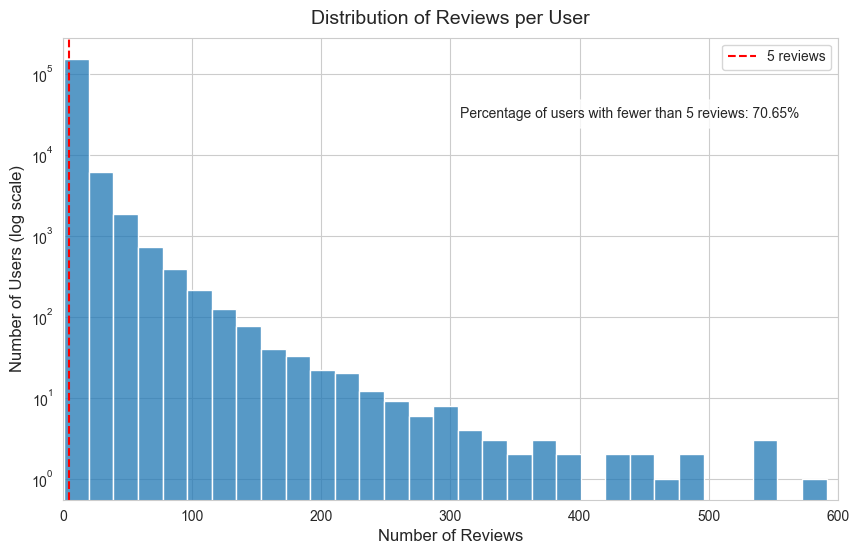

Percentage of businesses with fewer than 5 reviews: 0.00%


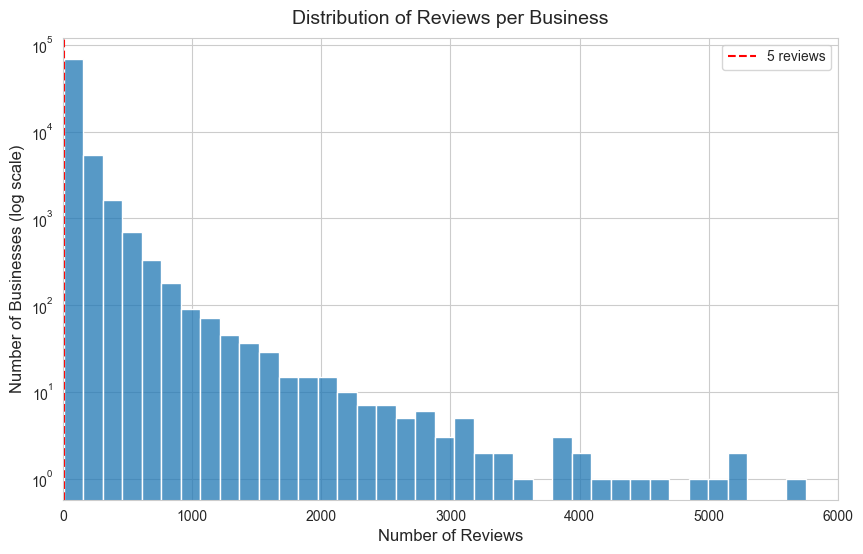

Matrix Sparsity: 0.9999
Matrix Density: 0.0001
Actual interactions: 980418
Possible interactions: 11790436855


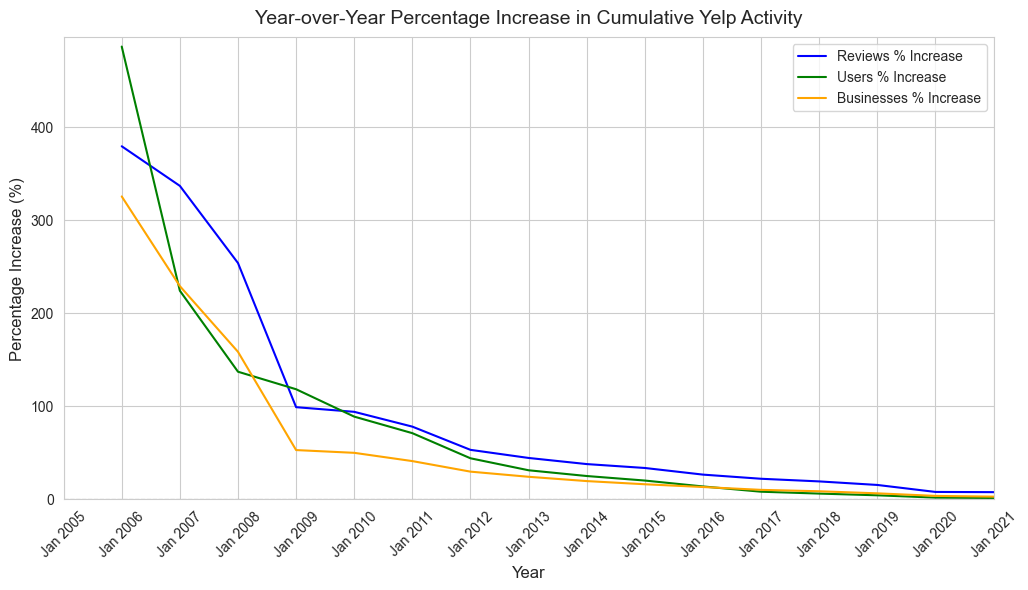

In [75]:
# data sparity
analyze_user_reviews(df_review)
analyze_business_reviews(df_business)
calculate_sparsity(df_review)
analyze_temporal(df_review, df_business, df_user)

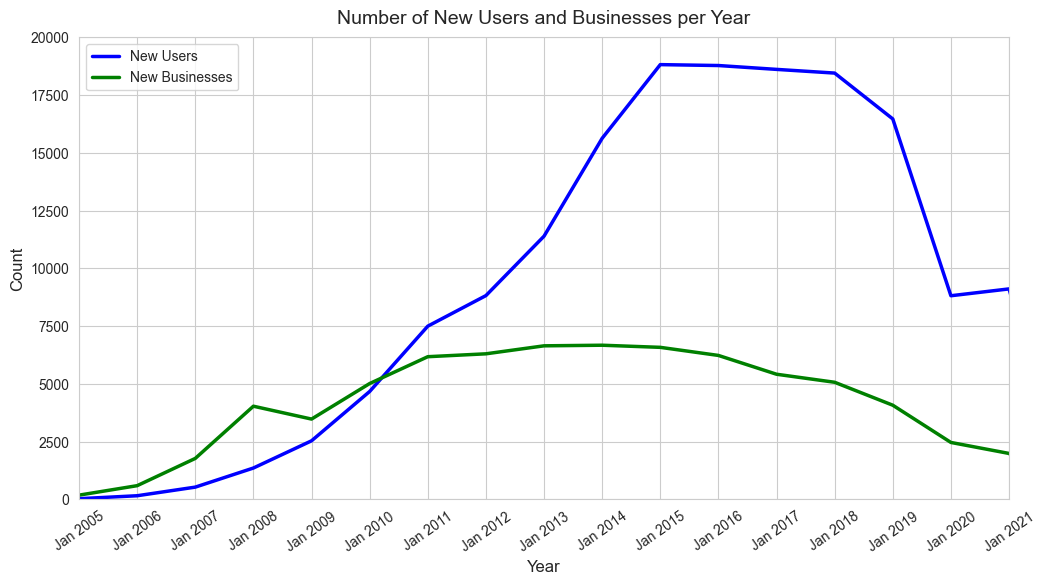

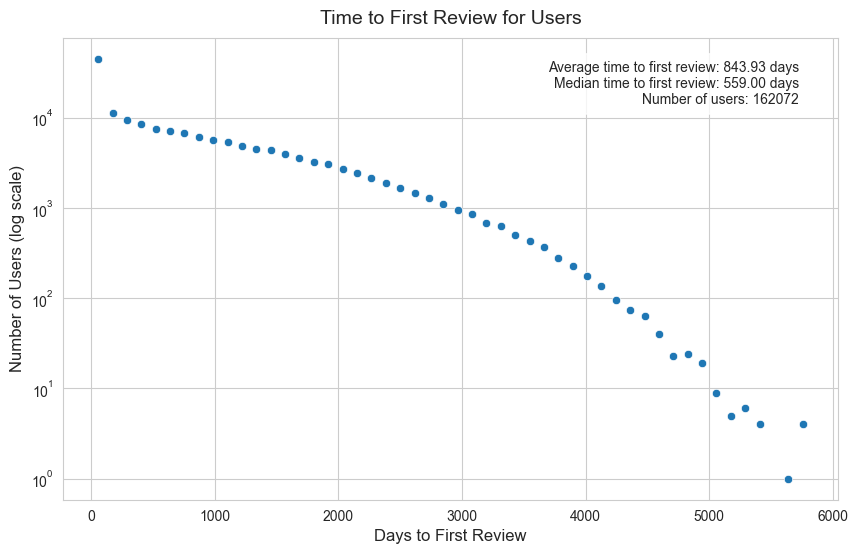

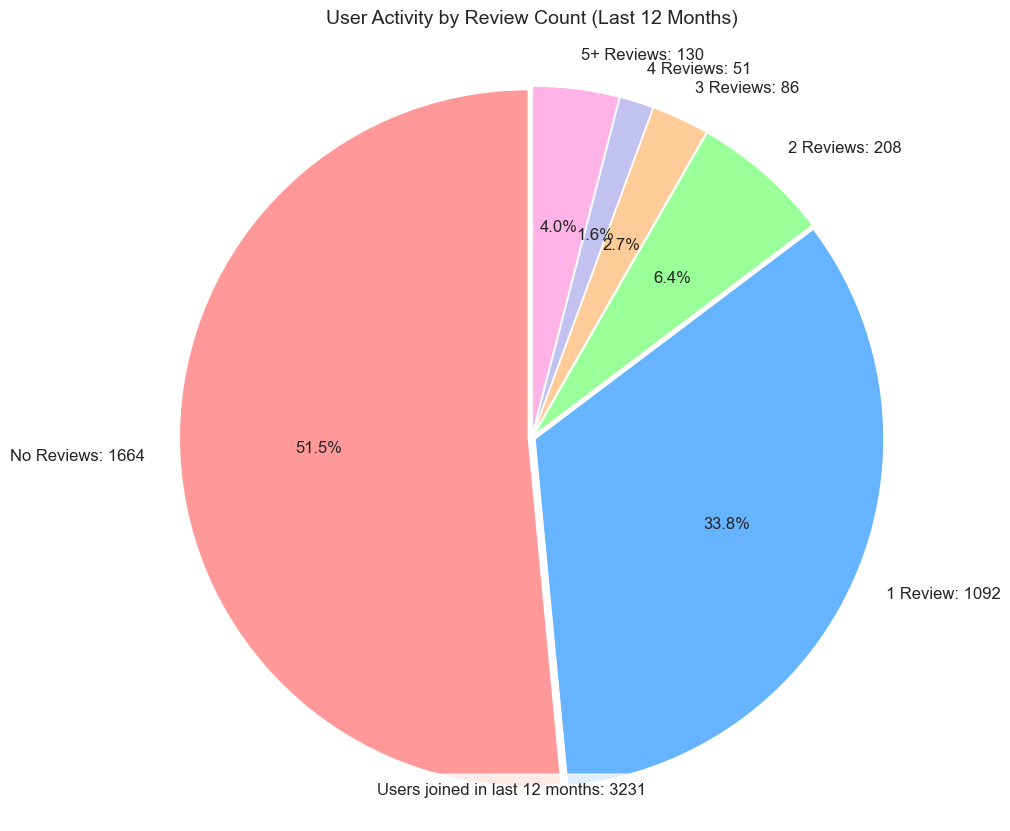

C:\Users\cathy\AppData\Local\Temp\ipykernel_17152\3068426274.py:192: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([new_businesses['review_count'], old_businesses['review_count']],


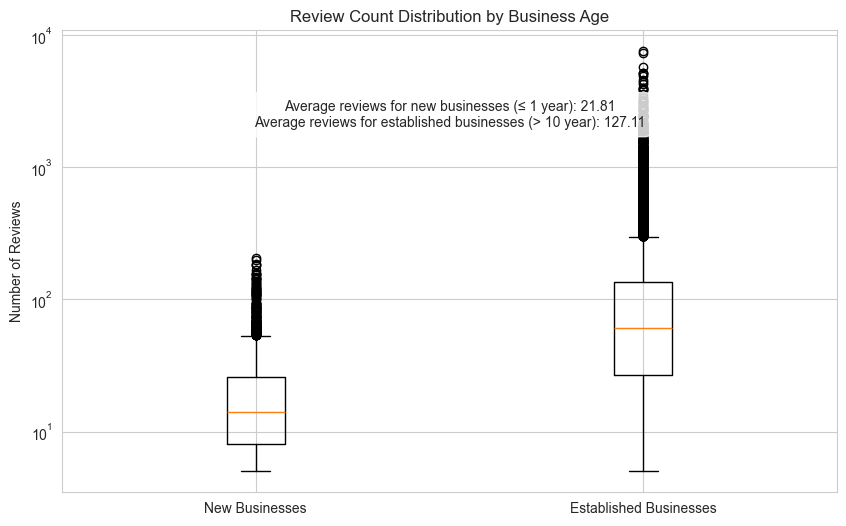

In [76]:
# Cold Start
analyze_new_entities(df_review, timeframe='year')
time_to_first_review(df_review, df_user)
user_tenure_reviews(df_review, df_user, months=12)
business_exposure(df_review, df_business)

Top 20% of businesses receive 67.15% of total reviews


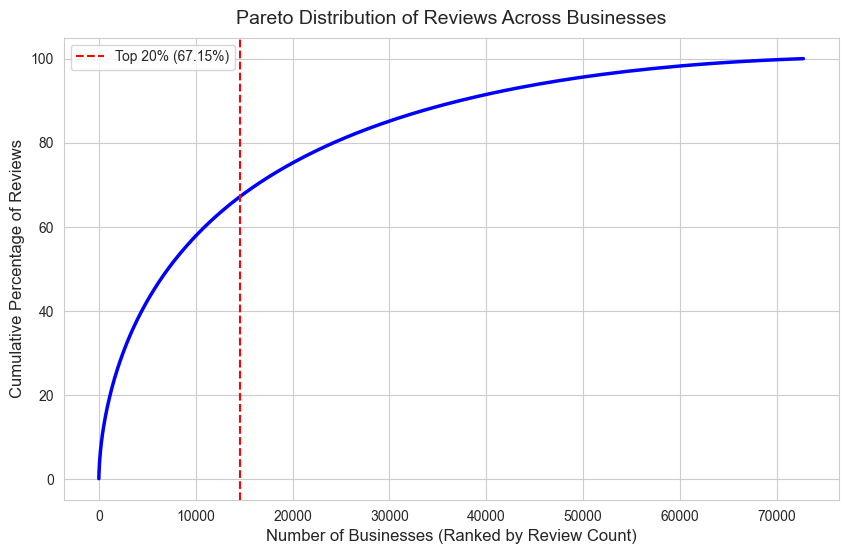

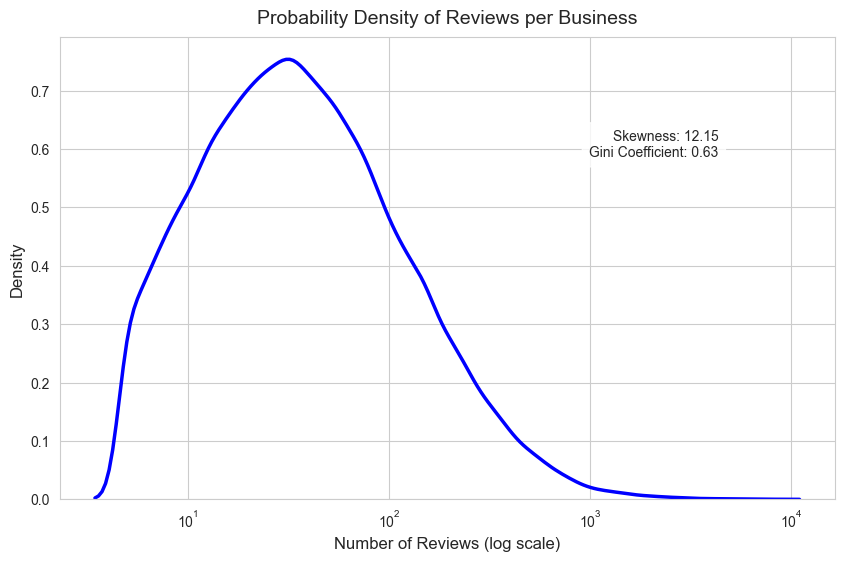

In [77]:
# Long tail
pareto(review_counts)
pdf(review_counts)